In [1]:
import json
import os
import string
from typing import Dict, List

from collections import Counter
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# Hacky fix for lib import error
try:
    from gensim.parsing.preprocessing import remove_stopwords
except:
    from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering

import cudf
from cuml import AgglomerativeClustering as cumlAgglomerativeClustering

In [2]:
# Helper functions for file IO
def read_json(filename: str) -> List[str]:
    """
    Returns a list from the JSON file
    """
    try:
        with open(filename, "r", encoding="utf-8") as f:
            data_json = json.load(f)
        return data_json
    except Exception as e:
        print("Error reading file with exception", e)
        return []

def write_json(filename: str, data: Dict[str, List[str]]) -> bool:
    """
    Saves the data in a json
    """
    try:
        with open(filename, "w", encoding="utf-8") as f:
            json.dump(data, f)
        return True
    except Exception as e:
        print("Error writing file with exception", e)
        return False



In [3]:
output_path = "results"
if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)
FILENAME = "data/rawTrends.json"

In [4]:
# Read the input json
data = read_json(FILENAME)

In [5]:
# Remove all empty strings
data = [d for d in data if d]

data = sorted(data)
np_data = np.array(data)

In [6]:
# Naive word based grouping
data_dict = Counter(data)

used = [False] * len(data)
data_set = [set(d.split(" ")) for d in data]

groups = {}
groups_stats = {}

for i, data_i in (pbar:= tqdm(enumerate(data), total=len(data), mininterval=10)):
    pbar.set_description(f"Processing {i} used = {sum(used)}/{len(data)}", refresh=False)

    if used[i]:
        continue
    groups[data_i] = []
    groups_stats[data_i] = 1
    for j in range(i + 1, len(data)):
        if data_set[i].intersection(data_set[j]):
            used[j] = True
            groups[data_i].append(data[j])
            groups_stats[data_i] += 1

write_json("{}/naive_grouping.json".format(output_path), groups)

  0%|          | 0/158806 [00:00<?, ?it/s]

True

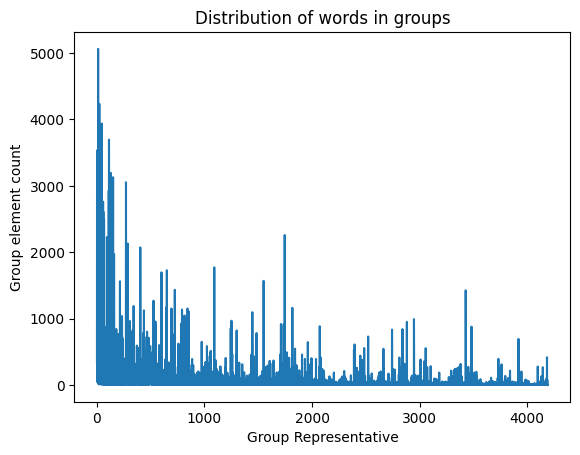

In [7]:
groups_keys = list(range(len(groups_stats.keys())))
groups_cnt = list(groups_stats.values())

plt.plot(groups_keys, groups_cnt)
plt.title('Distribution of words in groups')
plt.xlabel('Group Representative')
plt.ylabel('Group element count')
plt.show()

In [8]:
groups_stats_df = pd.DataFrame(groups_cnt)
groups_stats_df.describe()

,0
count,4194.000000
mean,79.466857
std,287.096851
min,1.000000
25%,2.000000
50%,9.000000
75%,41.000000
max,5063.000000


In [9]:
data_df = pd.DataFrame(data, columns=["Trends"])

# Remove stopwords and punctuation
# Not removing digits as they may be important
data_df['Trends'] = data_df['Trends'].apply(lambda text: ' '.join(
    [remove_stopwords(item).translate(str.maketrans('','',string.punctuation)) \
     for item in text.split()]
))

# Lemmitize and make lower case
# Using Lemmitization and not stemming 
# for more getting a more correct root word
def stemSentence(sentence):
    lemmatizer = WordNetLemmatizer()
    token_words = word_tokenize(sentence)
    stem_sentence = [lemmatizer.lemmatize(word.lower()) for word in token_words]
    return ' '.join(stem_sentence)

data_df['Trends'] = data_df['Trends'].apply(lambda text: stemSentence(text))
data_df.head()

,Trends
0,1 piece wonder
1,1 shoulder cocktail frock
2,1 shoulder top
3,10 gore skirt
4,100 cashmere


In [10]:
# Using TF-IDF (word level) for getting embeddings
# I tried to use some pretrained NLP embedding models but results were not good
vectorizer = TfidfVectorizer(analyzer='word')
X = vectorizer.fit_transform(data_df["Trends"])
X.shape

(158806, 19523)

In [11]:
# Applying PCA to reduce dimensions
# The calculated TF-IDF matrix is very spare
# and has as many feature dims as unique words in the data
# Using n_components=100 for clustering fast
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
print("TF-IDF vector dim =", X.shape)
print("PCA    vector dim =", X_pca.shape)

TF-IDF vector dim = (158806, 19523)
PCA    vector dim = (158806, 100)


In [12]:
# Preparing features for GPU clustering
X_df = pd.DataFrame({'f%d'%i: X_pca[:, i] for i in range(X_pca.shape[1])})
X_gpu = cudf.DataFrame.from_pandas(X_df)

In [13]:
# Preparing for Agglomarative clustering
clustering_parameters = {
    "n_clusters": 60000,
    "n_neighbors": 100,
    "metric": "cosine",
    "connectivity": "knn"
}
amc_gpu = cumlAgglomerativeClustering(**clustering_parameters)

In [14]:
%%time

# predicting clusters for each entry in the data
y_amc_gpu = amc_gpu.fit_predict(X_gpu)
y_amc_gpu.describe()

CPU times: user 4.23 s, sys: 187 ms, total: 4.42 s
Wall time: 4.66 s


count    158806.000000
mean      12410.430116
std       17468.360179
min           0.000000
25%         345.000000
50%        2618.000000
75%       20297.750000
max       59999.000000
dtype: float64

In [15]:
print("Number of clusters =", len(y_amc_gpu.unique()))

Number of clusters = 60000


In [16]:
# Moving array from device(gpu) to host(cpu)
y_amc_gpu = y_amc_gpu.to_numpy()

In [17]:
# Saving Results
unique_entries = []
unique_clusters = {}
for i in range(clustering_parameters["n_clusters"]):
    cluster = np_data[y_amc_gpu == i]
    cluster = sorted(cluster)
    unique_entries.append(cluster[0])
    unique_clusters[cluster[0]] = cluster

write_json("{}/unique_entries.json".format(output_path), {"0": unique_entries})
write_json("{}/unique_clusters.json".format(output_path), unique_clusters)

True

In [18]:
zero_cnt = 0
threshold_cnt = 0
threshold_elem_cnt = 0
cluster_stats = {}
for i in range(clustering_parameters["n_clusters"]):
    cluster = np_data[y_amc_gpu == i]
    size_of_cluster = len(cluster)
    if size_of_cluster == 0:
        zero_cnt += 1
    if size_of_cluster > 20:
        threshold_cnt += 1
        threshold_elem_cnt += size_of_cluster
    cluster_stats[str(cluster[0])] = size_of_cluster

print("Found {} empty clusters".format(zero_cnt))
print("Found {} clusters with more than 20 elements totaling {} elements".format(threshold_cnt, threshold_elem_cnt))


Found 0 empty clusters
Found 574 clusters with more than 20 elements totaling 67836 elements


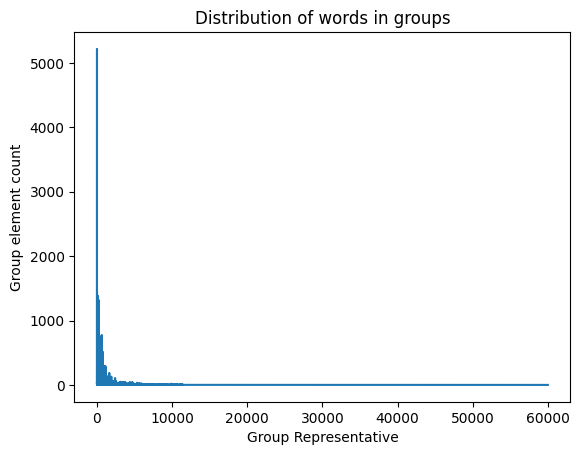

In [19]:
cluster_keys = list(range(len(cluster_stats.keys())))
cluster_cnt = list(cluster_stats.values())

plt.plot(cluster_keys, cluster_cnt)
plt.title('Distribution of words in groups')
plt.xlabel('Group Representative')
plt.ylabel('Group element count')
plt.show()

In [20]:
cluster_stats_df = pd.DataFrame(cluster_stats.values())
cluster_stats_df.describe()

,0
count,60000.000000
mean,2.646767
std,29.413153
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,5216.000000


In [21]:
# Having many elements in one cluster is a problem.
# That means there isn't much information in the embedding
# to differentiate between a pair of sentences.

# Possible solutions and ideas which I couldn't experiment.
# Enrich each entry in the list with LLM generated description with a prompt like
# "Describe the given words with less than 30 words. Reply with only the description. Reply should scritly be within 30 words. Reply must be as specific and concise as possible
# Topic: {topic}"
# Once we have description for all trend topics, we can calculate the TF-IDF based on the desciptions
# and cluster based on these new embeddings.

# Using embeddings from a Embedding pretrained model.
# I tried using embeddings from a small model, but results weren't good.
# Maybe due to small size of model. I haven't investigated in depth on this.